In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import illustris_python as il
import os


In [2]:
def masses(df):
    keys = df.keys()
    for key in keys:
        if "Mass" in key:
            df[key] = df[key]*10**10
    return df

def color(df):
    df["SubhaloColor_g-i"] = df["SubhaloStellarPhotometrics_g"] - df["SubhaloStellarPhotometrics_i"]
    return df

In [3]:
def late_type_SFR(df):
    """
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["SubhalosSFR"] < 0.036].index
    df_copy = df_copy.drop(index_names)
    """
    df_copy = df.copy(deep=True)
    index_names_1 = df_copy[df_copy["SubhalosSFR"] > 0.36].index
    df_copy = df_copy.drop(index_names_1)
    index_names_2 = df_copy[df_copy["SubhalosSFR"] < 0.036].index
    df_copy = df_copy.drop(index_names_2)
    
    return df_copy

def early_type_SFR(df):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["SubhalosSFR"] > 0.01148].index
    df_copy = df_copy.drop(index_names)
    return df_copy

def late_type_gas(df):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["SubhaloGasFraction"] < 0.1].index #Ferrero2020
    df_copy = df_copy.drop(index_names)
    return df_copy

def early_type_gas(df):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["SubhaloGasFraction"] > 0.1].index #Ferrero2020
    df_copy = df_copy.drop(index_names)
    return df_copy

def late_type_kappa(df):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["Kappa_rot"] < 0.6].index #Ferrero2020
    df_copy = df_copy.drop(index_names)
    return df_copy

def early_type_kappa(df):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["Kappa_rot"] > 0.6].index #Ferrero2020
    df_copy = df_copy.drop(index_names)
    return df_copy


In [4]:
old = pd.read_pickle("../data/tng-100-1/cutdata/Subhalo_Centrals_minE9_5_SM.pkl")
new = pd.read_pickle("../data/tng-100-1/catalogues/kappa_rot_2602.pkl")

old.sort_values(by="id", inplace = True)
new.sort_values(by="id", inplace = True)

print(len(old), len(new))

#Masses
old = masses(old)
new = masses(new)

#sSFR
new["SubhalosSFR"] = 10**(9)*new["SubhaloSFR"]/new["SubhaloMassStellar"]
new["SubhaloGasFraction"] = new["SubhaloMassGas"]/new["SubhaloMassStellar"]

old["SubhalosSFR"] = 10**(9)*old["SubhaloSFR"]/old["SubhaloMassStellar"]
old["SubhaloGasFraction"] = old["SubhaloMassInRadGas"]/old["SubhaloMassInRadStellar"]

#Adding color
new = color(new)
old = color(old)


5877 5433


In [5]:
import h5py
result = {}
with h5py.File("../data/tng-100-3/catalogues/stellar_circs.hdf5", "r") as f:
    header = dict(f['Header'].attrs.items())
    fields = list(f["Snapshot_99"].keys())
    for field in fields:
        result[field] = np.array(f["Snapshot_99"][field])
    kinematics = result
print(kinematics["SpecificAngMom"])

[12610.998     1418.9609    2682.5693   ...    42.777134   221.87273
   341.50983 ]


In [6]:
#Make sure the same galaxies are selected, create late/early type catalogues
new_earlies = early_type_SFR(early_type_gas(new))
new_lates = late_type_SFR(late_type_gas(new))

#new_earlies = early_type_gas(new)
#new_lates = late_type_gas(new)

#new_earlies = early_type_kappa(early_type_gas(new))
#new_lates = late_type_kappa(late_type_gas(new))

new_earlies_id = new_earlies["id"].values
new_lates_id = new_lates["id"].values
new_id = new["id"].values

old_earlies = old[old["id"].isin(new_earlies_id)]
old_lates = old[old["id"].isin(new_lates_id)]
old = old[old["id"].isin(new_id)]

print(len(new), len(old))

5433 5433


In [7]:
#Log format
new_log = il.formatplot.log_formater(new)
old_log = il.formatplot.log_formater(old)
new_earlies_log = il.formatplot.log_formater(new_earlies)
old_earlies_log = il.formatplot.log_formater(old_earlies)
new_lates_log = il.formatplot.log_formater(new_lates)
old_lates_log = il.formatplot.log_formater(old_lates)

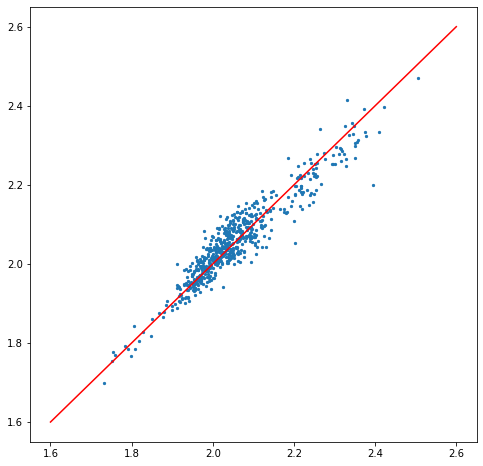

In [26]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
old_vals_log = old_earlies_log["SubhaloVelDisp"].values
new_vals_log = new_earlies_log["SubhaloVelDisp"].values

axs.scatter(old_vals_log, new_vals_log, s=5)

x = np.linspace(1.6, 2.6)
axs.plot(x, x, c="red", label = "y=x")

#il.formatplot.SM_SM(ax=axs)


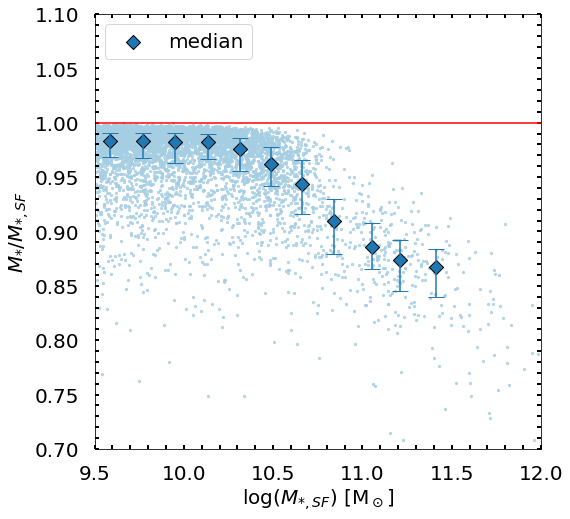

In [9]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
old_vals_log = old_log["SubhaloMassStellar"].values
old_vals = old["SubhaloMassStellar"].values
new_vals = new["SubhaloMassStellar"].values

frac = new_vals/old_vals

x_med, y_med, x_err, y_err = il.stats.median_errors(old_vals_log, frac, 9.5, 11.5)

axs.scatter(old_vals_log, frac, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values
axs.errorbar(x_med, y_med, yerr=y_err, capsize = 8, color="#1f78b4", marker='^', fmt = 'none')
axs.scatter(x_med, y_med, marker='D', s=100, color="#1f78b4", edgecolors = "black", label = r"median")

x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red")

il.formatplot.SM_fSM(ax=axs, y0=0.7, y1=1.1)

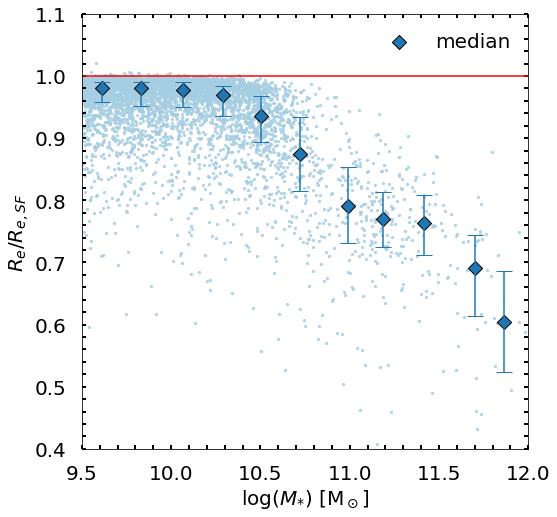

In [10]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
old_vals_log = old_log["SubhaloMassStellar"].values
old_vals = np.array(old["SubhaloHalfmassRadStellar"].values)
new_vals = np.array(new["SubhaloHalfmassRadStellar"].values)
frac = new_vals/old_vals

x_med, y_med, x_err, y_err = il.stats.median_errors(old_vals_log, frac, 9.5, 12)

axs.scatter(old_vals_log, frac, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values
axs.errorbar(x_med, y_med, yerr=y_err, capsize = 8, color="#1f78b4", marker='^', fmt = 'none')
axs.scatter(x_med, y_med, marker='D', s=100, color="#1f78b4", edgecolors = "black", label = r"median")
x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red")

il.formatplot.SM_fR(ax=axs, y0=0.4, y1=1.1)


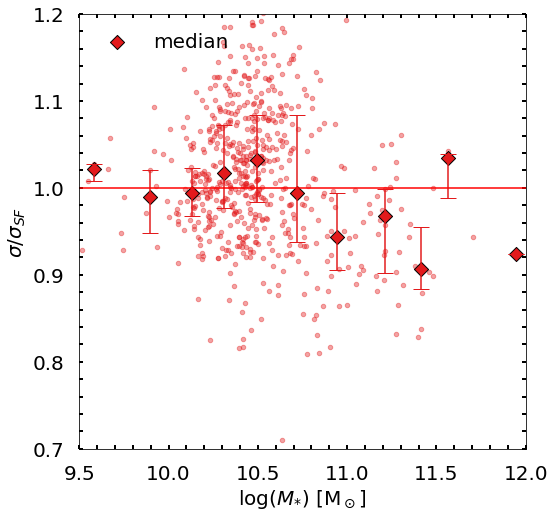

In [21]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
old_vals_log = old_earlies_log["SubhaloMassStellar"].values
old_vals = np.array(old_earlies["SubhaloVelDisp"].values)
new_vals = np.array(new_earlies["SubhaloVelDisp"].values)
frac = new_vals/old_vals

x_med, y_med, x_err, y_err = il.stats.median_errors(old_vals_log, frac, 9.5, 12)

axs.scatter(old_vals_log, frac, s=20, alpha=0.4, color="#e31a1c",)
#Plot median values
axs.errorbar(x_med, y_med, yerr=y_err, capsize = 8, color="#e31a1c", marker='^', fmt = 'none')
axs.scatter(x_med, y_med, marker='D', s=100, color="#e31a1c", edgecolors = "black", label = r"median")

x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red")

il.formatplot.SM_fVD(ax=axs, x0=9.5, x1=12, y0=0.7, y1=1.2)


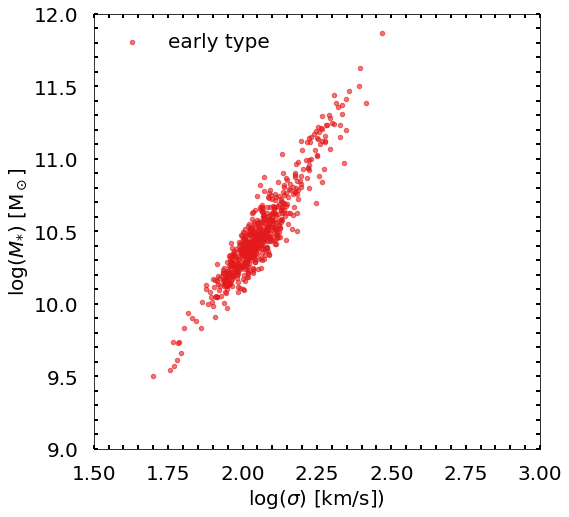

In [12]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points

new_earlies_log.plot.scatter(x="SubhaloVelDisp", y="SubhaloMassStellar", ax = axs, color = "#e31a1c", s=20, alpha=0.6, label = "early type")

il.formatplot.VD_SM(ax=axs)


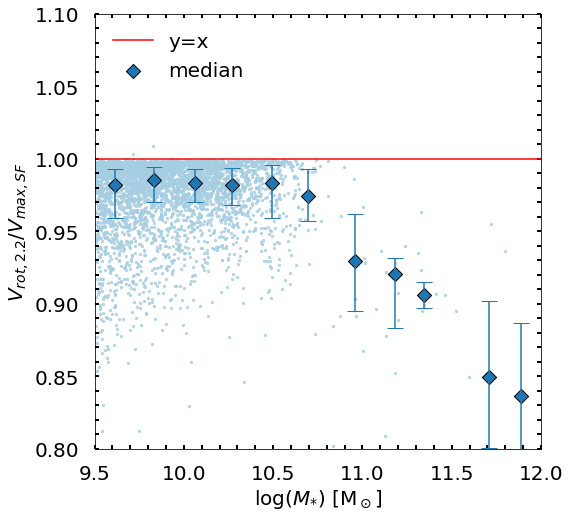

In [13]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
old_vals_log = old_lates_log["SubhaloMassStellar"].values
old_vals = np.array(old_lates["SubhaloVmax"].values)
new_vals = np.array(new_lates["SubhaloRotVel_2_2Re"].values)
frac = new_vals/old_vals

x_med, y_med, x_err, y_err = il.stats.median_errors(old_vals_log, frac, 9.5, 12)

axs.scatter(old_vals_log, frac, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values
axs.errorbar(x_med, y_med, yerr=y_err, capsize = 8, color="#1f78b4", marker='^', fmt = 'none')
axs.scatter(x_med, y_med, marker='D', s=100, color="#1f78b4", edgecolors = "black", label = r"median")

x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red", label = "y=x")

il.formatplot.SM_fV(ax=axs, y0=0.8, y1=1.1)


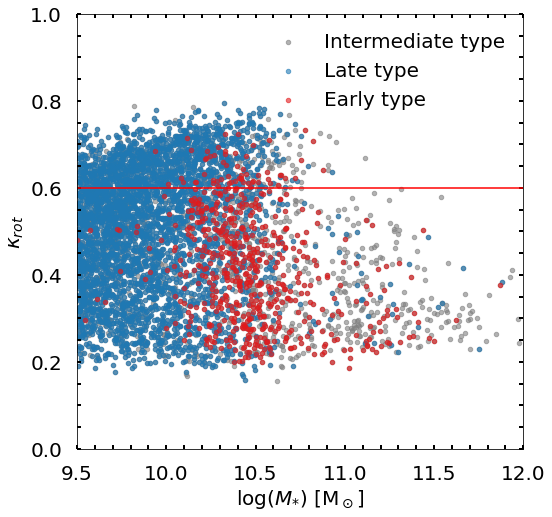

In [14]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points

new_log.plot.scatter(x="SubhaloMassStellar", y="Kappa_rot", ax = axs, color = "grey", s=20, alpha=0.6, label = "Intermediate type")
new_lates_log.plot.scatter(x="SubhaloMassStellar", y="Kappa_rot", ax = axs, color = "#1f78b4", s=20, alpha=0.6, label = "Late type")
new_earlies_log.plot.scatter(x="SubhaloMassStellar", y="Kappa_rot", ax = axs, color = "#e31a1c", s=20, alpha=0.6, label = "Early type")

x = np.linspace(9.5, 12, 2)
y = 2*[0.6]
axs.plot(x, y, c="red")

il.formatplot.SM_kappa(ax=axs, x0=9.5, x1=12, y0=0, y1 = 1)


In [15]:
vals = np.array(list(old["SubhaloLenType"].values))
star_vals = vals[:, 4]
print(star_vals.min())

4480


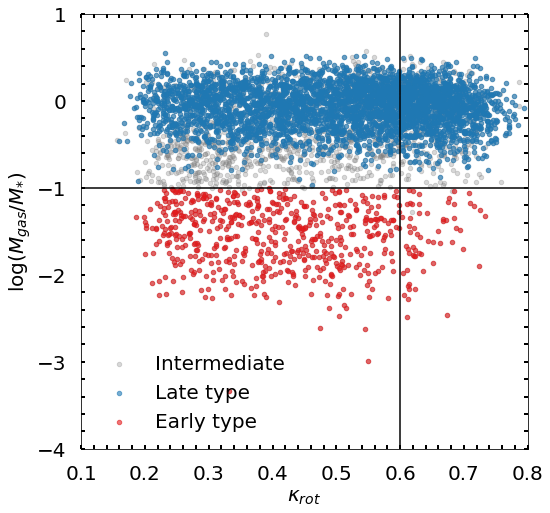

In [16]:
#old_cat["SubhaloGasFraction"] = old_cat["SubhaloMassInRadGas"]/old_cat["SubhaloMassInRadStellar"]

#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
new_log.plot.scatter(x="Kappa_rot", y="SubhaloGasFraction", ax = axs, color = "grey", s=20, alpha=0.3, label = "Intermediate")
new_lates_log.plot.scatter(x="Kappa_rot", y="SubhaloGasFraction", ax = axs, color = "#1f78b4", s=20, alpha=0.6, label = "Late type")
new_earlies_log.plot.scatter(x="Kappa_rot", y="SubhaloGasFraction", ax = axs, color = "#e31a1c", s=20, alpha=0.6, label = "Early type")

x = np.linspace(0, 1, 2)
y = 2*[-1]
axs.plot(x, y, c="black")

x_k = 2*[0.6]
y_k = np.linspace(-6, 1, 2)
axs.plot(x_k, y_k, c="black")

il.formatplot.kappa_fG(ax=axs, y0=-4, y1=1)
